Notebook to try to provide a data-augmented dataflow with balanced classes distribution

Idea is to create generator with balanced classes between batches

In [1]:
from __future__ import print_function
import os 
import sys
import numpy as np

sys.path.append("..")

import imp
image_preprocessor = imp.load_source('image_preprocessor', '../submissions/keras_cnns_pretrained/image_preprocessor.py')
transform = image_preprocessor.transform
transform_test = image_preprocessor.transform_test

from rampwf.workflows.image_classifier import BatchGeneratorBuilder
from rampwf.workflows.image_classifier import _chunk_iterator, _to_categorical, get_nb_minibatches
from problem import get_cv, get_train_data

### Check dataflow

In [2]:
n_classes = 403
batch_size = 8

In [3]:
folder_X_train, y_train = get_train_data(path="..")
cv = list(get_cv(folder_X_train, y_train))

for fold_i, (train_is, valid_is) in enumerate(cv):

    folder, X_train = folder_X_train

    gen_builder = BatchGeneratorBuilder(X_array=X_train[train_is], y_array=y_train[train_is], 
                                transform_img=transform, transform_test_img=transform_test, 
                                folder=folder, 
                                chunk_size=batch_size*5, 
                                n_classes=n_classes, n_jobs=1)
    break

In [8]:
import matplotlib.pylab as plt
%matplotlib inline

import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit

In [26]:
valid_ratio = 0.3
ssplit = StratifiedShuffleSplit(n_splits=1, test_size=valid_ratio)

train_indices, valid_indices = next(ssplit.split(gen_builder.X_array, gen_builder.y_array))
nb_train = len(train_indices)
nb_valid = len(valid_indices)

In [ ]:
classes_freq = np.where(class_counts > 500)[0]

In [22]:


# Under+Oversample training data:
# - undersample randomly images that count is larger a threshold
# - oversample randomly all images

undersampling_threshold = 500
train_indices_to_undersample = []

class_counts = np.zeros((403), dtype=np.int)
for class_index in gen_builder.y_array[train_indices]:
    class_counts[class_index] += 1

classes_to_undersample = np.where(class_counts > undersampling_threshold)[0]

In [23]:
classes_to_undersample

array([ 27,  57,  94,  97, 131, 134, 159, 202])

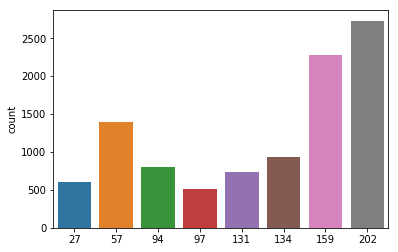

In [24]:
train_indices_to_undersample = [index for index in train_indices if gen_builder.y_array[index] in classes_to_undersample]
sns.countplot(gen_builder.y_array[train_indices_to_undersample])

In [ ]:
classes_to_undersample = np.where(class_counts > undersampling_threshold)[0]

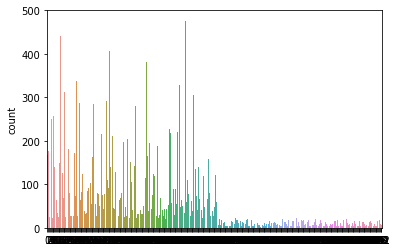

In [25]:
train_indices_to_oversample = [index for index in train_indices if gen_builder.y_array[index] not in classes_to_undersample]
sns.countplot(gen_builder.y_array[train_indices_to_oversample])

In [77]:
from imblearn.under_sampling import RandomUnderSampler

rs = RandomUnderSampler()

train_indices_undersampled, new_y_array = rs.fit_sample(np.array(train_indices_to_undersample)[:, None], gen_builder.y_array[train_indices_to_undersample])

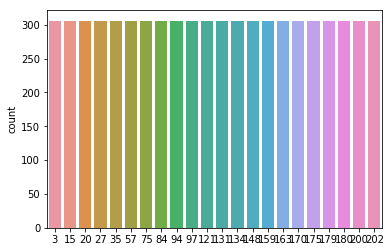

In [78]:
sns.countplot(new_y_array)

In [84]:
from imblearn.over_sampling import RandomOverSampler

rs = RandomOverSampler()

new_train_indices = np.concatenate((train_indices_undersampled, np.array(train_indices_to_oversample)[:, None]))
new_y_array = np.concatenate((new_y_array, gen_builder.y_array[train_indices_to_oversample]))

new_train_indices, new_y_array = rs.fit_sample(new_train_indices, new_y_array)

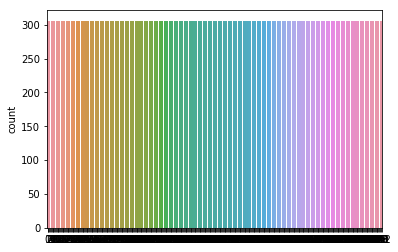

In [85]:
sns.countplot(new_y_array)

In [88]:
len(new_train_indices), len(new_y_array)

(123318, 123318)

In [106]:
from collections import defaultdict

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from joblib import delayed
from joblib import Parallel


def _chunk_iterator2(parallel, X_array, folder, y_array=None, chunk_size=1024):
    from skimage.io import imread
    for i in range(0, len(X_array), chunk_size):
        X_chunk = X_array[i:i + chunk_size]
        filenames = [os.path.join(folder, '{}'.format(x)) for x in X_chunk]
        X = parallel(delayed(imread)(filename) for filename in filenames)
        if y_array is not None:
            y = y_array[i:i + chunk_size]
            yield X, y
        else:
            yield X


def local_get_generator2(self, indices=None, batch_size=256):
    if indices is None:
        indices = np.arange(self.nb_examples)
    # Infinite loop, as required by keras `fit_generator`.
    # However, as we provide the number of examples per epoch
    # and the user specifies the total number of epochs, it will
    # be able to end.

    y_stats = defaultdict(int)
    with Parallel(n_jobs=self.n_jobs, backend='threading') as parallel:
        while True:

            # Display feeded dataset stats
            if len(y_stats) > 0:
                print("\n\n------------------------------------")
                print("Dataflow classes distribution : \n")
                for k in y_stats:
                    print("'{}': {} |".format(str(k), y_stats[k]), end=' \t ')
                print("\n\n------------------------------------\n\n")

            if self.shuffle:
                np.random.shuffle(indices)
            it = _chunk_iterator2(parallel,
                                  X_array=self.X_array[indices], folder=self.folder,
                                  y_array=self.y_array[indices], chunk_size=self.chunk_size)

            for X, y in it:
                # 1) Preprocessing of X and y
                X = parallel(delayed(self.transform_img)(x) for x in X)
                # X = np.array([self.transform_img(x) for x in X])
                # X is a list of numpy arrrays at this point, convert it to a
                # single numpy array.
                try:
                    X = [x[np.newaxis, :, :, :] for x in X]
                except IndexError:
                    # single channel
                    X = [x[np.newaxis, np.newaxis, :, :] for x in X]
                X = np.concatenate(X, axis=0)
                X = np.array(X, dtype='float32')

                for class_index in y:
                    y_stats[class_index] += 1

                # Convert y to onehot representation
                y = _to_categorical(y, num_classes=self.n_classes)

                # 2) Yielding mini-batches
                for i in range(0, len(X), batch_size):
                    yield X[i:i + batch_size], y[i:i + batch_size]
                    
                    
def local_get_train_valid_generators(self, batch_size=256, valid_ratio=0.3):
    """Build train and valid generators for keras.

    This method is used by the user defined `Classifier` to o build train
    and valid generators that will be used in keras `fit_generator`.

    Parameters
    ==========

    batch_size : int
        size of mini-batches
    valid_ratio : float between 0 and 1
        ratio of validation data

    Returns
    =======

    a 5-tuple (gen_train, gen_valid, nb_train, nb_valid, class_weights) where:
        - gen_train is a generator function for training data
        - gen_valid is a generator function for valid data
        - nb_train is the number of training examples
        - nb_valid is the number of validation examples
        - class_weights
    The number of training and validation data are necessary
    so that we can use the keras method `fit_generator`.
    """
    
    if valid_ratio > 0.0:
        ssplit = StratifiedShuffleSplit(n_splits=1, test_size=valid_ratio)

        train_indices, valid_indices = next(ssplit.split(self.X_array, self.y_array))        
        gen_valid = self._get_generator(indices=valid_indices, batch_size=batch_size)
        nb_valid = len(valid_indices)

    else:
        train_indices = np.arange(self.nb_examples)        
        gen_valid = None
        nb_valid = None


    # Under+Oversample training data:
    # - undersample randomly images that count is larger a threshold
    # - oversample randomly all images

    undersampling_threshold = 300
    train_indices_to_undersample = []

    class_counts = np.zeros((403), dtype=np.int)
    for class_index in self.y_array[train_indices]:
        class_counts[class_index] += 1

    classes_to_undersample = np.where(class_counts > undersampling_threshold)[0]

    train_indices_to_undersample = [index for index in train_indices if self.y_array[index] in classes_to_undersample]
    train_indices_to_oversample = [index for index in train_indices if self.y_array[index] not in classes_to_undersample]

    rs = RandomUnderSampler()

    train_indices_undersampled, new_y_array = rs.fit_sample(np.array(train_indices_to_undersample)[:, None], 
                                                            self.y_array[train_indices_to_undersample])                
    rs = RandomOverSampler()
    new_train_indices = np.concatenate((train_indices_undersampled, np.array(train_indices_to_oversample)[:, None]))
    new_y_array = np.concatenate((new_y_array, self.y_array[train_indices_to_oversample]))

    new_train_indices, _ = rs.fit_sample(new_train_indices, new_y_array)   
    new_train_indices = new_train_indices.ravel()
    gen_train = self._get_generator(indices=new_train_indices, batch_size=batch_size)
    nb_train = len(new_train_indices)        
            
    self.nb_examples = nb_train + 0 if nb_valid is None else nb_valid

    class_weights = defaultdict(int)
    max_count = 0
    
    for class_index in self.y_array[new_train_indices]:
        class_weights[class_index] += 1
        if class_weights[class_index] > max_count:
            max_count = class_weights[class_index]
    for class_index in class_weights:
        class_weights[class_index] = np.log(1.0 + (max_count / class_weights[class_index])**2)

    return gen_train, gen_valid, nb_train, nb_valid, class_weights

In [107]:
import types 

gen_builder._get_generator = types.MethodType(local_get_generator2, gen_builder)
gen_builder.get_train_valid_generators = types.MethodType(local_get_train_valid_generators, gen_builder)
gen_builder.n_jobs = 8
gen_builder.shuffle = True

### Check batch data distrubution

In [108]:
gen_train, gen_valid, nb_train, nb_valid, class_weights = gen_builder.get_train_valid_generators(batch_size=batch_size)

In [109]:
nb_train

123318

In [110]:
import matplotlib.pylab as plt
%matplotlib inline

import seaborn as sns

In [116]:
from collections import defaultdict, Hashable

total_y_stats = defaultdict(int)


max_counter = 100 # len(train_ids) // batch_size
for batch_images, batch_labels in gen_train:

    y_stats = defaultdict(int)
    print('-----------------')
    print("%i" % max_counter, end=' | ')
    for y in batch_labels:
        class_index = np.where(y > 0)[0][0]
        print("%i" % class_index, end=' ')
        if isinstance(class_index, Hashable):
            total_y_stats[class_index] += 1 
            y_stats[class_index] += 1
    print('')
    
    if max_counter % 10 == 0:
        print("\n%i | Labels counts: " % max_counter)

        print("  current: | ", end='')
        for k in y_stats:
            print("'{}': {} |".format(str(k), y_stats[k]), end=' ')
        print('')
        print("    total: | ", end='')
        for k in total_y_stats:
            print("'{}': {} |".format(str(k), total_y_stats[k]), end=' ')
        print('')   
    
    max_counter -= 1
    if max_counter == 0:
        break

-----------------
100 | 247 59 19 81 248 173 135 156 

100 | Labels counts: 
  current: | '135': 1 | '173': 1 | '81': 1 | '19': 1 | '247': 1 | '248': 1 | '59': 1 | '156': 1 | 
    total: | '135': 1 | '173': 1 | '81': 1 | '19': 1 | '247': 1 | '248': 1 | '59': 1 | '156': 1 | 
-----------------
99 | 223 213 217 391 83 268 195 390 
-----------------
98 | 345 351 78 5 202 386 361 207 
-----------------
97 | 79 35 382 64 400 41 330 383 
-----------------
96 | 251 359 71 306 320 71 224 34 
-----------------
95 | 322 301 324 386 385 381 171 369 
-----------------
94 | 398 85 259 162 110 349 353 84 
-----------------
93 | 310 247 66 154 306 73 296 174 
-----------------
92 | 5 140 318 305 218 258 192 109 
-----------------
91 | 365 302 181 254 94 103 342 27 
-----------------
90 | 303 49 120 274 25 4 51 189 

90 | Labels counts: 
  current: | '4': 1 | '303': 1 | '49': 1 | '274': 1 | '51': 1 | '120': 1 | '25': 1 | '189': 1 | 
    total: | '320': 1 | '386': 2 | '171': 1 | '4': 1 | '5': 2 | '390':

-----------------
55 | 347 360 39 283 393 172 17 142 
-----------------
54 | 397 327 243 35 156 107 15 136 
-----------------
53 | 332 321 53 82 128 32 335 235 
-----------------
52 | 118 59 334 77 8 192 285 104 
-----------------
51 | 24 151 230 345 102 183 380 319 
-----------------
50 | 353 52 3 345 29 348 183 44 

50 | Labels counts: 
  current: | '353': 1 | '3': 1 | '44': 1 | '52': 1 | '183': 1 | '345': 1 | '348': 1 | '29': 1 | 
    total: | '3': 1 | '4': 1 | '5': 2 | '8': 1 | '9': 1 | '10': 1 | '12': 2 | '14': 1 | '15': 3 | '17': 5 | '19': 2 | '20': 3 | '23': 1 | '24': 1 | '25': 3 | '26': 1 | '27': 2 | '29': 1 | '30': 1 | '32': 3 | '34': 1 | '35': 3 | '36': 1 | '37': 2 | '39': 1 | '41': 2 | '44': 1 | '46': 3 | '47': 1 | '48': 2 | '49': 3 | '50': 2 | '51': 2 | '52': 1 | '53': 2 | '57': 1 | '58': 1 | '59': 5 | '60': 2 | '62': 2 | '64': 2 | '65': 3 | '66': 2 | '68': 1 | '71': 2 | '72': 2 | '73': 1 | '74': 1 | '76': 1 | '77': 5 | '78': 1 | '79': 1 | '81': 1 | '82': 1 | '83': 1 | '84'

-----------------
25 | 66 317 383 212 387 314 196 195 
-----------------
24 | 10 265 230 37 277 338 76 45 
-----------------
23 | 180 386 274 217 60 397 323 213 
-----------------
22 | 172 165 37 70 75 80 267 251 
-----------------
21 | 396 213 212 287 175 249 290 368 
-----------------
20 | 225 156 108 290 291 395 276 119 

20 | Labels counts: 
  current: | '225': 1 | '290': 1 | '291': 1 | '395': 1 | '108': 1 | '276': 1 | '119': 1 | '156': 1 | 
    total: | '1': 2 | '3': 3 | '4': 1 | '5': 2 | '8': 1 | '9': 3 | '10': 2 | '11': 2 | '12': 2 | '13': 1 | '14': 1 | '15': 3 | '17': 5 | '19': 2 | '20': 3 | '23': 1 | '24': 1 | '25': 4 | '26': 1 | '27': 3 | '29': 1 | '30': 1 | '31': 1 | '32': 4 | '33': 1 | '34': 1 | '35': 3 | '36': 2 | '37': 4 | '39': 2 | '41': 2 | '43': 1 | '44': 2 | '45': 1 | '46': 4 | '47': 1 | '48': 4 | '49': 3 | '50': 2 | '51': 3 | '52': 1 | '53': 3 | '54': 1 | '56': 1 | '57': 2 | '58': 2 | '59': 5 | '60': 3 | '61': 2 | '62': 3 | '63': 2 | '64': 4 | '65': 3 | '66': 4 | '68

-----------------
5 | 360 191 357 351 127 72 290 336 
-----------------
4 | 222 283 232 184 85 318 311 83 
-----------------
3 | 179 258 127 346 209 376 156 32 
-----------------
2 | 384 377 138 299 195 78 168 313 
-----------------
1 | 30 329 161 245 32 101 45 155 


In [117]:
len(total_y_stats), n_classes

(352, 403)

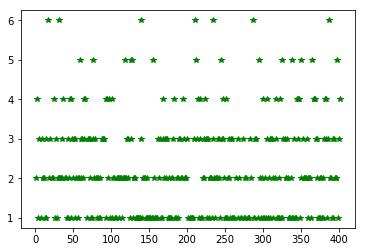

In [118]:
plt.plot(list(total_y_stats.keys()), list(total_y_stats.values()), 'g*')